# Описание проекта

HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом. Аналитики, опираясь на методы машинного обучения,предлагают, как избежать финансовых потерь и оттока сотрудников. 
По ходу проекта будет несколько задач:
1. построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика.
2. построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

## Задача 1: предсказание уровня удовлетворённости сотрудника

### Загрузка данных

In [1]:
#!pip install numpy==1.26.2 pandas==2.1.4 matplotlib==3.8.2 seaborn==0.13.1 scikit-learn==1.5.1 phik==0.12.4 shap==0.46.0 -q

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
import phik
import shap

from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

from sklearn.preprocessing import (OneHotEncoder, OrdinalEncoder, LabelEncoder,
                                   StandardScaler, MinMaxScaler, RobustScaler, PolynomialFeatures, LabelEncoder)
from sklearn.impute import SimpleImputer

from sklearn.metrics import (make_scorer,
                             roc_auc_score, f1_score, accuracy_score,
                             mean_squared_error, root_mean_squared_error, mean_absolute_error, r2_score)

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

#инициализация моделей
from sklearn.tree         import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.svm          import SVC, SVR
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors    import KNeighborsClassifier
from sklearn.ensemble     import RandomForestRegressor, RandomForestClassifier

from sklearn.pipeline import Pipeline,  make_pipeline
from sklearn.compose import ColumnTransformer


import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", 30)

In [3]:
RANDOM_STATE = 1000

Здесь будем хранить функции, которые будут использованы по ходу работы

In [4]:
# функция для проврки уникальных значений качественных признаков
# я ее использую, чтобы наглядно посмотреть есть ли неявные дубликаты
def unique_check(**dfs):
    for df_name, df in dfs.items():
        categorical = []
        for col in df.columns:
            if df[col].dtype == 'O':
                categorical.append(col)
        for column in categorical:
            print(f'Датафрейм {df_name}. Колонка {column} - ее уникальные значения {df[column].unique()}')
        print()

# функция для отображения лучших моделей, найденных с помощью RandomizedSearchCV или GridSearchCV
def display_best_models_grided(grid_or_randomized_search, *mods):
    result = pd.DataFrame(grid_or_randomized_search.cv_results_).sort_values('rank_test_score')
    mod1 = result[[isinstance(clf, mods[0]) for clf in result['param_models']]].head(1)
    for mod in mods[1:]:
        mod1 = pd.concat([mod1, 
                          result[[isinstance(clf, mod) for clf in result['param_models']]].head(1)])
    display(mod1.sort_values(by='rank_test_score'))

In [5]:
try:
    test_features = pd.read_csv('test_features.csv')
    test_target_job_satisfaction_rate = pd.read_csv('test_target_job_satisfaction_rate.csv')
    train_job_satisfaction_rate = pd.read_csv('train_job_satisfaction_rate.csv')
except:
    test_features = pd.read_csv('https://code.s3.yandex.net/datasets/test_features.csv')
    test_target_job_satisfaction_rate = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_job_satisfaction_rate.csv')
    train_job_satisfaction_rate = pd.read_csv('https://code.s3.yandex.net/datasets/train_job_satisfaction_rate.csv')  

Признаковое описание:
* **id** — уникальный идентификатор сотрудника;
* **dept** — отдел, в котором работает сотрудник;
* **level** — уровень занимаемой должности;
* **workload** — уровень загруженности сотрудника;
* **employment_years** — длительность работы в компании (в годах);
* **last_year_promo** — показывает, было ли повышение за последний год;
* **last_year_violations** — показывает, нарушал ли сотрудник трудовой договор за последний год;
* **supervisor_evaluation** — оценка качества работы сотрудника, которую дал руководитель;
* **salary** — ежемесячная зарплата сотрудника;
* **job_satisfaction_rate** — уровень удовлетворённости сотрудника работой в компании, целевой признак.

In [6]:
dict = {'test_features':test_features, 
        'test_target_job_satisfaction_rate':test_target_job_satisfaction_rate, 
        'train_job_satisfaction_rate':train_job_satisfaction_rate}

for name, dfr in dict.items():
    print('Информация по таблице', name)
    display(dfr.head(5))
    print('Количество пропусков в таблице:', dfr.isna().sum().sum())
    dups = dfr.duplicated().sum().sum()
    print('Количество явных дубликатов в таблице:', dfr.duplicated().sum().sum())
    print()
    print(dfr.info())
    print()
    print()

Информация по таблице test_features


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


Количество пропусков в таблице: 3
Количество явных дубликатов в таблице: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB
None


Информация по таблице test_target_job_satisfaction_rate


,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


Количество пропусков в таблице: 0
Количество явных дубликатов в таблице: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB
None


Информация по таблице train_job_satisfaction_rate


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


Количество пропусков в таблице: 10
Количество явных дубликатов в таблице: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB
None




### Предобработка данных

In [7]:
unique_check(test_features=test_features, 
             test_target_job_satisfaction_rate=test_target_job_satisfaction_rate, 
             train_job_satisfaction_rate=train_job_satisfaction_rate)

Датафрейм test_features. Колонка dept - ее уникальные значения ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
Датафрейм test_features. Колонка level - ее уникальные значения ['junior' 'middle' 'sinior' nan]
Датафрейм test_features. Колонка workload - ее уникальные значения ['medium' 'low' 'high' ' ']
Датафрейм test_features. Колонка last_year_promo - ее уникальные значения ['no' 'yes']
Датафрейм test_features. Колонка last_year_violations - ее уникальные значения ['no' 'yes']


Датафрейм train_job_satisfaction_rate. Колонка dept - ее уникальные значения ['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
Датафрейм train_job_satisfaction_rate. Колонка level - ее уникальные значения ['junior' 'middle' 'sinior' nan]
Датафрейм train_job_satisfaction_rate. Колонка workload - ее уникальные значения ['medium' 'high' 'low']
Датафрейм train_job_satisfaction_rate. Колонка last_year_promo - ее уникальные значения ['no' 'yes']
Датафрейм train_job_satisfaction_rate. Колонка last_

В таблице test_features обаружено 3 пропуска, в таблице train_job_satisfaction_rate 10 пропусков. Данные пропуски будут удалены в пайплайне. Одно "нестандартное значение" в колонке 'workload', которое будет заменено аналогично в пайплайне.

### Исследовательский анализ данных

Для исследования возьмем тренировочные данные train_job_satisfaction_rate, на которых будем обучать модели машинного обучения.

In [8]:
train_job_satisfaction_rate.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [9]:
quantitative_cols = ['salary', 'job_satisfaction_rate', 'employment_years']
category_cols = ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations', 'supervisor_evaluation']

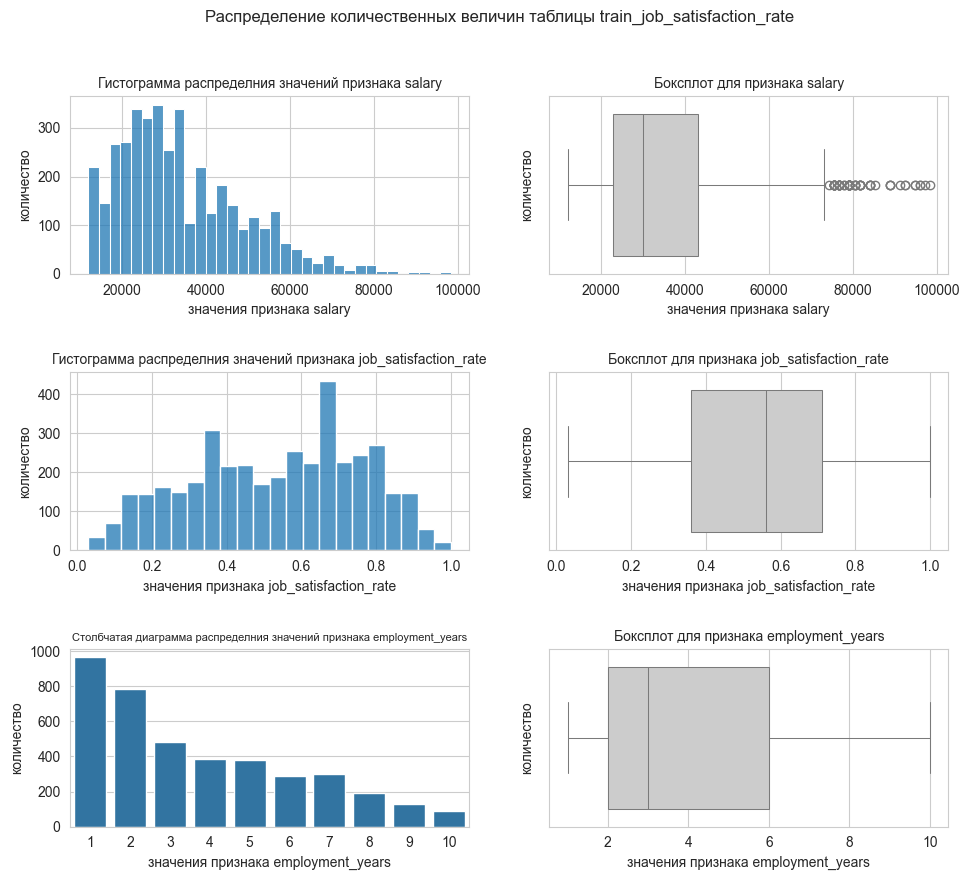

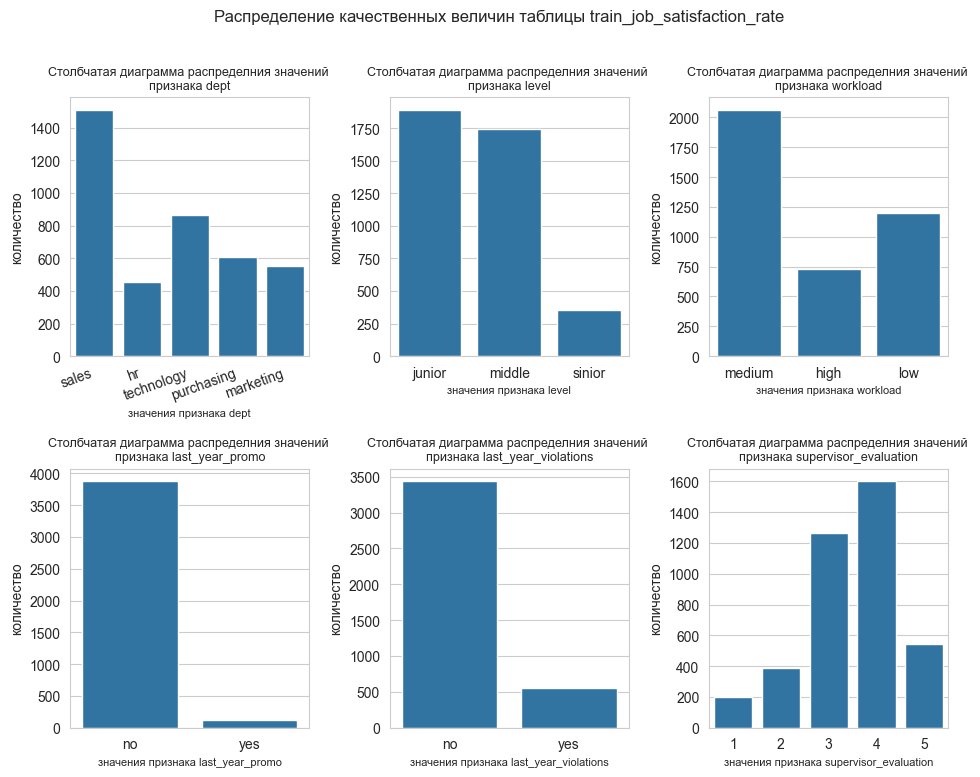

In [10]:
fig, axs = plt.subplots(3, 2, figsize=(10, 9))
fig.suptitle('Распределение количественных величин таблицы train_job_satisfaction_rate')
fig.tight_layout(pad=3, h_pad=5)

for i, param in enumerate(quantitative_cols):
    if param == 'employment_years':
        sns.countplot(data=train_job_satisfaction_rate, x=param, ax=axs[i, 0])
        axs[i, 0].set_title(f'Столбчатая диаграмма распределния значений признака {param}', fontsize=8)
    else:
        sns.histplot(data=train_job_satisfaction_rate, x=param, ax=axs[i, 0])
        axs[i, 0].set_title(f'Гистограмма распределния значений признака {param}', fontsize=10)
    sns.boxplot(data=train_job_satisfaction_rate, x=param, ax=axs[i, 1], color=".8", linewidth=.75, orient='h')   
    axs[i, 0].set_ylabel(f'количество')
    axs[i, 1].set_ylabel(f'количество')
    axs[i, 0].set_xlabel(f'значения признака {param}')
    axs[i, 1].set_xlabel(f'значения признака {param}')
    axs[i, 1].set_title(f'Боксплот для признака {param}', fontsize=10)
    


fig, axs = plt.subplots(2, 3, figsize=(10, 8))
fig.suptitle('Распределение качественных величин таблицы train_job_satisfaction_rate')
fig.tight_layout(pad=3, h_pad=6)
for i, param in enumerate(category_cols):
    sns.countplot(data=train_job_satisfaction_rate, x=param, ax=axs[i//3, i%3])
    axs[i//3, i%3].set_title(f'Столбчатая диаграмма распределния значений \nпризнака {param}', fontsize=9)
    axs[i//3, i%3].set_ylabel(f'количество')
    axs[i//3, i%3].set_xlabel(f'значения признака {param}', fontsize=8)

axs[0,0].set_xticks(ticks=axs[0,0].get_xticks(), labels=axs[0,0].get_xticklabels(), rotation=20, ha='right')
plt.show()

In [11]:
Q1 = np.percentile(train_job_satisfaction_rate['salary'], 25)
Q3 = np.percentile(train_job_satisfaction_rate['salary'], 75)
IQR = Q3 - Q1
Q3 + 1.5 * IQR

73800.0

Ознакамливаясь с графиками можно подметить несколько интересных особенностей:
* Самая популярная зарплата - около 30000. Данный параметр имеет статистические выбросы запралат работников на позиции sinior с зп от 73800. Некоторые модели (например линейные) могут быть к этому слишком чувствительны. Однако избавиться от них нельзя, иначе модели будет сложно предсказывать отток (удовлетворение) высококвалифицированных сотрудников.
* Удовлетворенность (в среднем) оставляет желать лучшего - чуть больше 0.50. Это наш целевой признак, его мы должны предсказывать.
* Получить повышение - большая редкость, даже нарушения трудового договора происходят чаще.
* Средняя оценка работника от руководителя - 3-4 балла.

Перед подготовкой данных проверим наличие линейной зависимости между входными признаками.

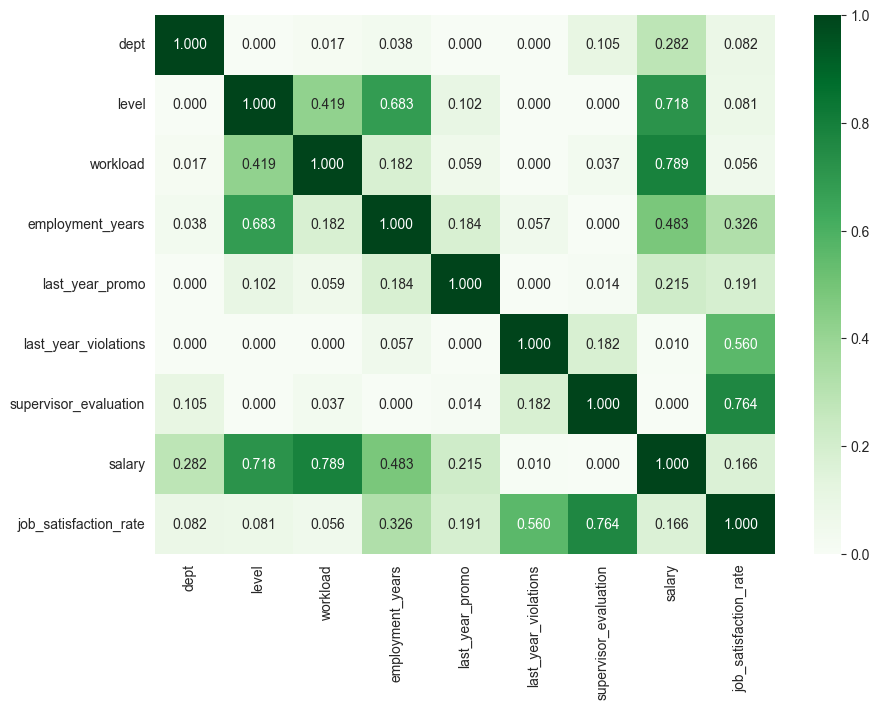

In [12]:
fig, axs = plt.subplots(1, 1, figsize=(10, 7))
sns.heatmap(train_job_satisfaction_rate.drop('id', axis=1).phik_matrix(interval_cols=['salary', 'job_satisfaction_rate']), annot=True, cmap='Greens', fmt=".3f", ax=axs)
plt.show()

Мультиколлинеарность между входными признаками не выявлена. Можно отметить низкую зависимость между целевым признаком и такими признаками как отдел, квалификация и степень загруженности.

### Подготовка данных

В этом шаге объединим тренировочную, тестовую выборку и создадим пайпланы для масштабирования и кодировки данных. На всякий случай предварительно объединим таблицы test_features и test_target_job_satisfaction_rate на случай если порядок id пользователей не совпадает. 

In [13]:
test_data = test_features.merge(test_target_job_satisfaction_rate, on='id')
test_data.isna().sum()

id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64

In [14]:
train_job_satisfaction_rate.drop(['id'], axis=1).duplicated().sum()

245

После удаления признака с id работника у нас появится 245 явных дубликатов. Это следует предусмотреть и до разбиения на выборки удалить дубликаты

In [15]:
train_job_satisfaction_rate = train_job_satisfaction_rate[~train_job_satisfaction_rate.drop(['id'], axis=1).duplicated()]

<div class="alert alert-success">
<b>ОТЛИЧНО! 👍</b>

Отлично! Таргеты теста объединяются с фичами теста по id!

В данные тестовой выборки добавлен целевой признак. И добавлен верно - объединение выполнено по id.

</div>

Количество пропусков не изменилось, значит объединение прошло успешно.

In [16]:
X_train = train_job_satisfaction_rate.drop(['id', 'job_satisfaction_rate'], axis=1)
y_train = train_job_satisfaction_rate['job_satisfaction_rate']
X_test = test_data.drop(['id', 'job_satisfaction_rate'], axis=1)
y_test = test_data['job_satisfaction_rate']

<div class="alert alert-danger">
<b>Необходимо исправить ❌</b>

После удаления признака id (или перевода его в индекс) из данных (обычно это имеет смысл делать перед обучением моделей МО, т.к. это не информативный признак) нужно проверить наличие (новых) дубликатов в данных: так как мы удалили часть лишних признаков, у нас могут появиться новые явные дубликаты: чем меньше признаков остаётся, тем выше шанс, что значения остальных признаков будут пересекаться. При этом ценности для модели такие наблюдения уже не принесут, поэтому стоит проверить дубликаты также в финальной версии таблицы.
    
При этом важно проверить только train: наличие дубликатов в test нам никак не мешает, но это правильное решение с точки зрения неприкосновенности test, ведь реальный поток данных (который имитирует test-выборка) мы исправить не сможем. А вот наличие дубликатов в train не только не принесёт пользы модели, но может и навредить.
</div>

<div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='4682B4'><u><b>КОММЕНТАРИЙ СТУДЕНТА</b></u></font>
    <br />
    <font color='4682B4'>

Поправил. Теперь даже интересно сравнить как это отразится на результатах.

</font>
</div>

In [17]:
ohe_cols = ['last_year_promo', 'last_year_violations']
ord_cols = ['level', 'dept', 'workload', 'supervisor_evaluation']
num_cols = ['salary', 'employment_years']

<div class="alert alert-danger">
<b>Необходимо исправить ❌</b>

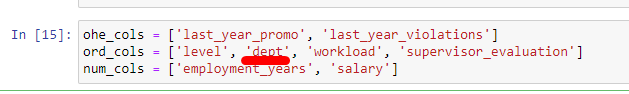
    
А почему ты считаешь что hr **лучше** чем маркетинг? По какому критерию такой порядок возможен?
    
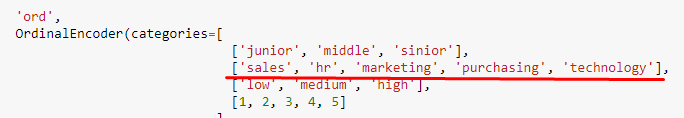    
</div>

<div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='4682B4'><u><b>КОММЕНТАРИЙ СТУДЕНТА</b></u></font>
    <br />
    <font color='4682B4'>

Ну в данном случае hr, наверное, хуже/меньше чем маркетинг)))

У меня было несколько вариантов решения:
1. Применить OHE. Мне кажется не лучший вариант, много признаков.
2. Интегрировать LabelEncoder для единственного признака. (я мог тоже отсторировать признак в лексикографическом порядке и получается кодировка была бы аналогичная LabelEncoder)
3. Сделсть ctrl+c ctrl+v из .unique(), просто чтобы уже имеющийся кодировщик работал. Чем мой порядок хуже порядка LabelEncoder?

Я выбрал самый простой и быстрый для меня вариант 3, которой помимо удобства обладает еще рядом плюсов:
* ORD отлично отработает пустые строки в тестовой таблице в этой задаче и в следующей
* не придется возится с FunctionTransformer, потому что LabelEncoder не может быть использован напрямую в пайплайне, так как он ожидает одномерный массив в качестве входных данных.


Я не опирался ни на какой критерий оценки. Если этот момент критичен, я засуну LabelEncoder,OHE или буду гуглить другие encoderы, но с твоего позволения, я бы хотел оставить это так.

</font>
</div>

In [18]:
ohe_pipe = Pipeline([
    (
        'simpleimputer_ohe', 
         SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    ),
    (
        'ohe', 
        OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
    )
])

ord_pipe = Pipeline([
    (
        'simpleimputer_before_ord', 
         SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    ),
    (
        'ord', 
        OrdinalEncoder(categories=[
                                    ['junior', 'middle', 'sinior'],
                                    ['sales', 'hr', 'marketing', 'purchasing', 'technology'],
                                    ['low', 'medium', 'high'],
                                    [1, 2, 3, 4, 5]
                                  ],
                       handle_unknown='use_encoded_value', 
                       unknown_value=np.nan
                      )
    ),
    (
        'simpleimputer_fater_ord', 
         SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    )
])

#итоговый пайплайн для подготовки данных
data_preprocessor = ColumnTransformer([
    ('ohe', ohe_pipe, ohe_cols),
    ('ord', ord_pipe, ord_cols),
    ('num', StandardScaler(), num_cols)
], remainder='passthrough')

<div class="alert alert-success">
<b>ОТЛИЧНО! 👍</b>

OneHotEncoder и/или OrdinalEncoder у тебя настроен на работу с неизвестными категориями. Это гарантия того, что твой код "не упадет" когда встретит (например в проде) значение, которое он (код) не видел на этапе обучения модели! ОТЛИЧНО!
</div>

### Обучение моделей

Создадим итоговый пайалайн для обучения модели

In [19]:
pipeline = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

In [20]:
pipeline = pipeline.fit(X_train, y_train)

В качествене метрики успеха будем использовать SMAPE (симметричное среднее абсолютное процентное отклонение).

In [21]:
def smape(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    if np.size(y_true) != np.size(y_pred):
        return print('Ошибка! Разная размерность вводимых данных.')
    return 100 * np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred)))

In [22]:
smape_scorer = make_scorer(smape, greater_is_better=False)

Посмотрим какие результаты у модели без подбора гиперпараметров

In [23]:
y_pred = pipeline.predict(X_test)
smape(y_test, y_pred)

14.357880657517608

Критерий успеха: SMAPE ≤ 15 на тестовой выборке. Результат уже удовлетворительный. Посмотрим получится ли улучшить его с помощью подбора гиперпапметров, изменения способа кодировки или модели.

In [24]:
param_num_scaler = [StandardScaler(), MinMaxScaler(), RobustScaler()]

In [25]:
rand_param_grid = [
    # словарь для модели DecisionTreeRegressor
    {
        'models':[DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth':range(10, 21, 2),
        'models__max_features':range(5, 8),
        'models__min_samples_split':range(5, 11),

        'preprocessor__num':['passthrough']       
    },
    # словарь для модели RandomForestRegressor
    {
        'models': [RandomForestRegressor(random_state=RANDOM_STATE)],
        'models__n_estimators': range(100, 401, 50),
        'models__max_depth': [None, 10, 20, 30],
        'models__min_samples_leaf':range(2, 11, 2),
        'models__max_features':range(5, 8),

        'preprocessor__num':['passthrough']       
    },
    # словарь для модели SVR
    {
        'models': [SVR(kernel='linear')],
        'models__C': [0.01, 0.05, 0.1, 0.5, 1, 10, 15], 
        
        'preprocessor__num':param_num_scaler
    }
]

In [26]:
randomized_search =RandomizedSearchCV(pipeline,
                                rand_param_grid,
                                cv=5,
                                n_iter=100,
                                scoring=smape_scorer,
                                n_jobs=-1,
                                random_state=RANDOM_STATE)

In [27]:
randomized_search = randomized_search.fit(X_train, y_train)

In [28]:
result = pd.DataFrame(randomized_search.cv_results_).sort_values('rank_test_score')
y_test_pred = randomized_search.predict(X_test)

In [29]:
print('Всего обучено моделей:', result.shape[0])
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_, '\n')
print ('Метрика SMAPE лучшей модели на тренировочной выборке:', randomized_search.best_score_)

print(f'Метрика SMAPE на тестовой выборке:  {smape(y_test, y_test_pred)}')
print(f'Метрика RMSE на тестовой выборке:   {root_mean_squared_error(y_test, y_test_pred)}')
print(f'Метрика MAE на тестовой выборке:    {mean_absolute_error(y_test, y_test_pred)}')
print(f'Метрика R2 на тестовой выборке:     {r2_score(y_test, y_test_pred)}', '\n')

Всего обучено моделей: 100
Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleimputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
         

Результат 12.57% на тестовой выборке и лучший результат на CV среди остальных моделей, поэтому в качестве основной будем использовать модель RandomForestRegressor

In [30]:
display_best_models_grided(randomized_search, DecisionTreeRegressor, SVR, RandomForestRegressor)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessor__num,param_models__n_estimators,param_models__min_samples_leaf,param_models__max_features,param_models__max_depth,param_models,param_models__C,param_models__min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
57,1.651483,0.009640,0.060380,0.000972,passthrough,350.0,2.0,7.0,20,RandomForestRegressor(random_state=1000),NaN,NaN,"{'preprocessor__num': 'passthrough', 'models__...",-14.020240,-12.572943,-14.925461,-14.468957,-13.749886,-13.947497,0.795245,1
24,0.022435,0.002323,0.005314,0.000680,passthrough,NaN,NaN,7.0,18,DecisionTreeRegressor(random_state=1000),NaN,10.0,"{'preprocessor__num': 'passthrough', 'models__...",-15.203723,-14.882027,-16.067048,-16.266217,-14.292000,-15.342203,0.736623,41
83,4.268449,0.099398,0.026763,0.000498,RobustScaler(),NaN,NaN,NaN,NaN,SVR(kernel='linear'),10.0,NaN,"{'preprocessor__num': RobustScaler(), 'models_...",-25.543805,-25.910307,-26.788870,-25.957743,-24.152269,-25.670599,0.861608,98


Посмотрим как с тестовыми данными справилась вторая в рейтинге модель.

In [31]:
target_model = DecisionTreeRegressor

In [32]:
# находим строку с интересующей нас моделью
target_string = result[[isinstance(clf, target_model) for clf in result['param_models']]].iloc[0]

# создаем пайплайн из лучшей модели логистической регресси
data_preprocessor = ColumnTransformer(
    [
    ('ohe', ohe_pipe, ohe_cols),
    ('ord', ord_pipe, ord_cols),
    ('num', target_string['param_preprocessor__num'], num_cols)
    ], 
    remainder='passthrough'
)
best_pipeline_target_model = Pipeline([('preprocessor', data_preprocessor), 
                                        ('models', target_string['param_models'])
                                       ]
                                      )


best_pipeline_target_model.fit(X_train, y_train)

y_pred_trg = best_pipeline_target_model.predict(X_test)


print('Метрика SMAPE лучшей модели на тренировочной выборке:', target_string['mean_test_score'], '\n')
print(f'Метрика SMAPE на тестовой выборке:  {smape(y_test, y_pred_trg)}')
print(f'Метрика RMSE на тестовой выборке:   {root_mean_squared_error(y_test, y_pred_trg)}')
print(f'Метрика MAE на тестовой выборке:    {mean_absolute_error(y_test, y_pred_trg)}')
print(f'Метрика R2 на тестовой выборке:     {r2_score(y_test, y_pred_trg)}', '\n')

print('Pipeline наиблучшей target модели:')

display(target_string['params'])

Метрика SMAPE лучшей модели на тренировочной выборке: -15.342202979418634 

Метрика SMAPE на тестовой выборке:  14.428928613482613
Метрика RMSE на тестовой выборке:   0.08452783751869329
Метрика MAE на тестовой выборке:    0.06152588546176046
Метрика R2 на тестовой выборке:     0.8524501568641907 

Pipeline наиблучшей target модели:


{'preprocessor__num': 'passthrough',
 'models__min_samples_split': 10,
 'models__max_features': 7,
 'models__max_depth': 18,
 'models': DecisionTreeRegressor(random_state=1000)}

Да, значение метрики smape удовлетваряют не тестовых данных требованиям заказчика, но нельзя упускать тот факт, что могли они просто "подойти" для модели, поэтому опираться будем на значения кросс-валидации, а тут очевидное превосходство у модели RandomForestRegressor.

In [33]:
randomized_search.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleimputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleimputer_before_ord',...
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan)),
                                                                  ('simpleimputer_fater_ord',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['level', 'dept', 'workload',
                                                   'supervisor_evaluation']),
                                                 ('num', 'passthrough',
                                                  ['salary',
                                                   'employment_years'])])),
                ('models',
                 RandomForestRegressor(max_depth=20, max_features=7,
                                       min_samples_leaf=2, n_estimators=350,
                                       random_state=1000))])

In [34]:
importances = randomized_search.best_estimator_.named_steps['models'].feature_importances_

# Создание DataFrame для удобного отображения результатов
feature_importances = pd.DataFrame({
    'Наимнование признака':randomized_search.best_estimator_.named_steps['preprocessor'].get_feature_names_out(),
    'Важность': importances
}).sort_values('Важность').reset_index(drop=True)

### Вывод

Линайная модель звезд с неба не хватает. Возможно это свзяано с тем, что категориальных переменных значительно больше, чем количественных. Однако для  дерева решений это не проблема и лучшей моделью DecisionTreeRegressor с параметрами *max_depth=15, max_features=6, min_samples_leaf=3, min_samples_split=7*. Кодировщик RobustScaler, скорее всего, был выбран посколько он менее чувствителен в выбросам, которые мы обнаружили в признаке salary при исследовательском анализе.

In [35]:
best_regression_pipeline = randomized_search.best_estimator_
best_regression_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleimputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleimputer_before_ord',...
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan)),
                                                                  ('simpleimputer_fater_ord',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['level', 'dept', 'workload',
                                                   'supervisor_evaluation']),
                                                 ('num', 'passthrough',
                                                  ['salary',
                                                   'employment_years'])])),
                ('models',
                 RandomForestRegressor(max_depth=20, max_features=7,
                                       min_samples_leaf=2, n_estimators=350,
                                       random_state=1000))])

Ниже приведен график важности признаков для итоговой модели.

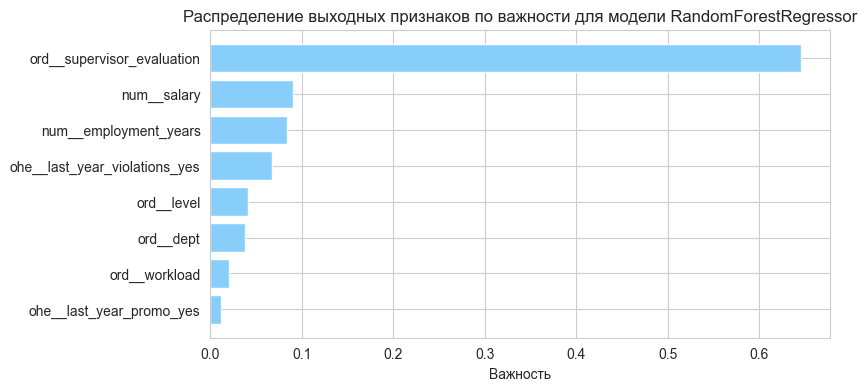

In [36]:
plt.figure(figsize=(8, 4))
plt.barh(feature_importances['Наимнование признака'], feature_importances['Важность'], color='lightskyblue')
plt.title('Распределение выходных признаков по важности для модели RandomForestRegressor')
plt.xlabel('Важность')
tree_feature_importances = plt.gcf()
plt.show()

Наиболее выжным признаком для принятия решений моделью выделена оценка руководителя. Тут я бы от себя добавил, что, наверное, не столько важна оценка руководителя, сколько взаимоотношения с ним. Мне кажется что эти признаки имели бы очень сильную корреляцию))) И получилось бы что чем лучше у тебя взаимоотношения с твоим руководителем - тем больше удовлетворенность работой.

## Задача 2: предсказание увольнения сотрудника из компании

### Загрузка данных

In [37]:
try:
    test_features_2 = pd.read_csv('second_task/test_features.csv')
    test_target_quit = pd.read_csv('second_task/test_target_quit.csv')
    train_quit = pd.read_csv('second_task/train_quit.csv')
except:
    test_features_2 = pd.read_csv('https://code.s3.yandex.net/datasets/test_features.csv')
    test_target_quit = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_quit.csv')
    train_quit = pd.read_csv('https://code.s3.yandex.net/datasets/train_quit.csv')  

In [38]:
dict = {'test_features_2':test_features_2, 
        'test_target_quit':test_target_quit, 
        'train_quit':train_quit}

for name, dfr in dict.items():
    print('Информация по таблице', name)
    display(dfr.head(5))
    print('Количество пропусков в таблице:', dfr.isna().sum().sum())
    dups = dfr.duplicated().sum().sum()
    print('Количество явных дубликатов в таблице:', dfr.duplicated().sum().sum())
    print()
    print(dfr.info())
    print()
    print()

Информация по таблице test_features_2


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


Количество пропусков в таблице: 3
Количество явных дубликатов в таблице: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB
None


Информация по таблице test_target_quit


,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


Количество пропусков в таблице: 0
Количество явных дубликатов в таблице: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB
None


Информация по таблице train_quit


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


Количество пропусков в таблице: 0
Количество явных дубликатов в таблице: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB
None




Скорее всего таблицы идентичны что можно проверить на таком примере:

In [39]:
test_features_2.sample(5, random_state=RANDOM_STATE)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
82,891385,sales,junior,medium,1,no,no,3,24000
1935,695964,technology,junior,low,1,no,no,4,24000
1639,366272,sales,junior,medium,1,no,no,5,21600
1591,562636,hr,junior,high,1,no,no,4,33600
1433,174065,sales,middle,medium,2,no,yes,2,40800


In [40]:
test_features.sample(5, random_state=RANDOM_STATE)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
82,891385,sales,junior,medium,1,no,no,3,24000
1935,695964,technology,junior,low,1,no,no,4,24000
1639,366272,sales,junior,medium,1,no,no,5,21600
1591,562636,hr,junior,high,1,no,no,4,33600
1433,174065,sales,middle,medium,2,no,yes,2,40800


Тестовые данные идентичны, поэтому будем использовать предыдущий датафрейм test_features

### Предобработка данных

Пропуски присутствуют в таблице test_features_2 3 штуки. Явные дубликаты отсутствуют везде.

In [41]:
unique_check(test_features_2=test_features_2,
             test_target_quit=test_target_quit, 
             train_quit=train_quit)

Датафрейм test_features_2. Колонка dept - ее уникальные значения ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
Датафрейм test_features_2. Колонка level - ее уникальные значения ['junior' 'middle' 'sinior' nan]
Датафрейм test_features_2. Колонка workload - ее уникальные значения ['medium' 'low' 'high' ' ']
Датафрейм test_features_2. Колонка last_year_promo - ее уникальные значения ['no' 'yes']
Датафрейм test_features_2. Колонка last_year_violations - ее уникальные значения ['no' 'yes']

Датафрейм test_target_quit. Колонка quit - ее уникальные значения ['yes' 'no']

Датафрейм train_quit. Колонка dept - ее уникальные значения ['sales' 'purchasing' 'marketing' 'technology' 'hr']
Датафрейм train_quit. Колонка level - ее уникальные значения ['middle' 'junior' 'sinior']
Датафрейм train_quit. Колонка workload - ее уникальные значения ['high' 'medium' 'low']
Датафрейм train_quit. Колонка last_year_promo - ее уникальные значения ['no' 'yes']
Датафрейм train_quit. Колонка last_year

Явные дубликаты отсутствуют.

### Исследовательский анализ данных

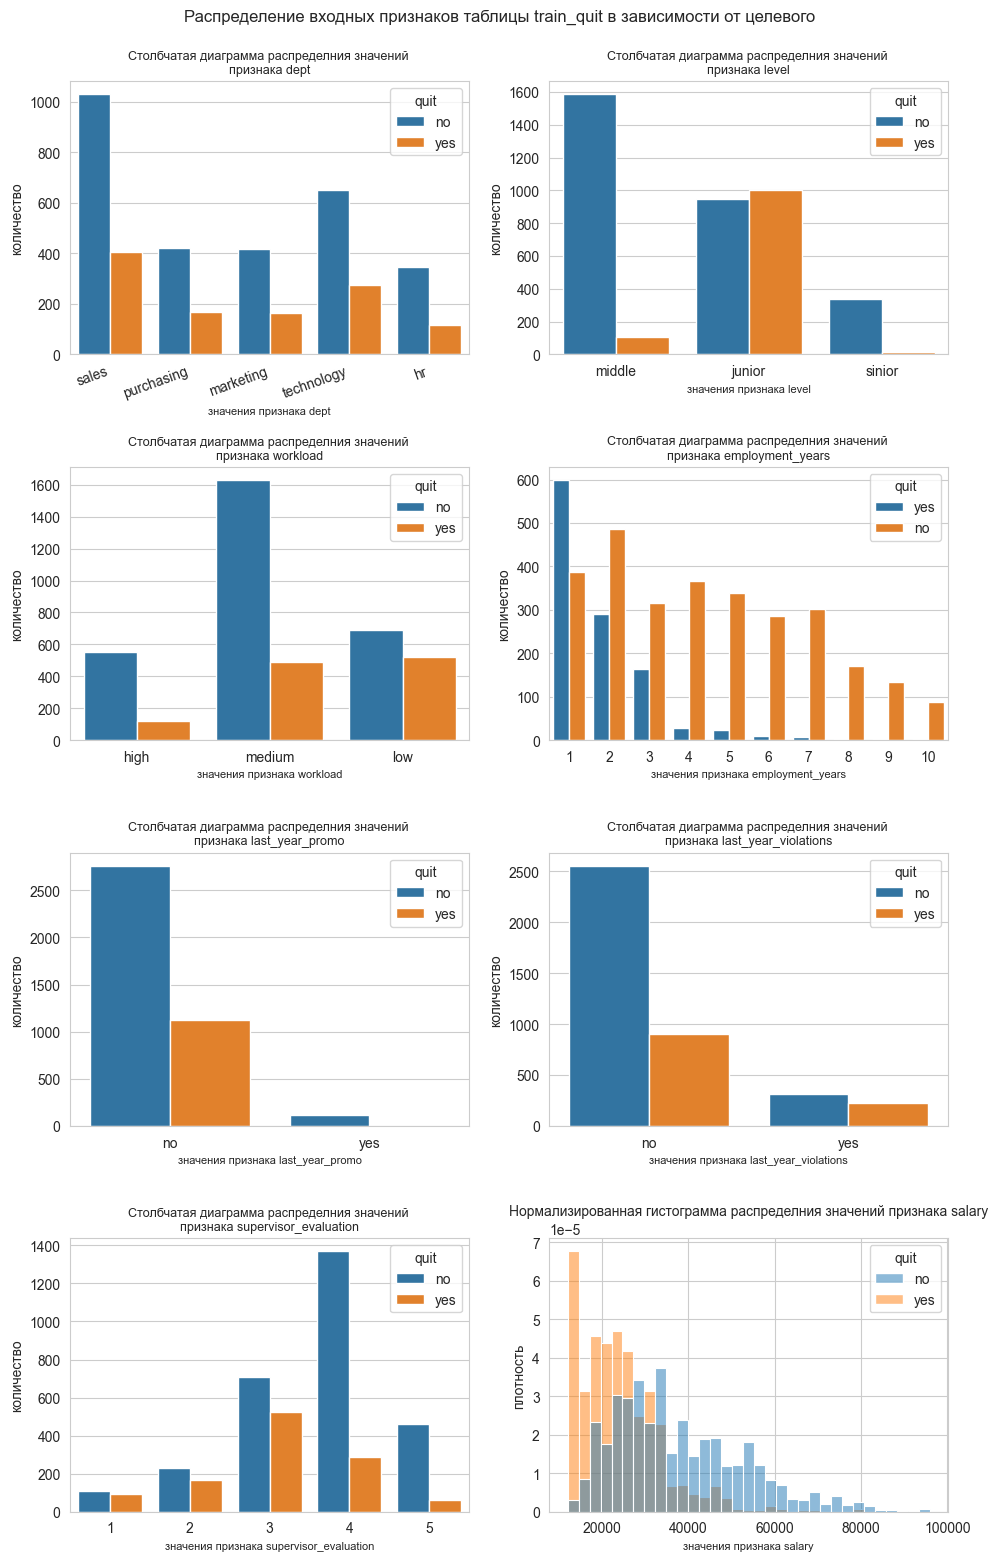

In [42]:
fig, axs = plt.subplots(4, 2, figsize=(10, 16))
fig.suptitle('Распределение входных признаков таблицы train_quit в зависимости от целевого')
fig.tight_layout(pad=3, h_pad=6)
for i, param in enumerate(train_quit.columns[1:-1]):
    ax = axs[i//2, i%2]
    if param == 'salary':
        sns.histplot(data=train_quit, x=param, hue='quit', stat='density', common_norm=False, ax=ax)
        ax.set_title(f'Нормализированная гистограмма распределния значений признака {param}', fontsize=10)
        ax.set_ylabel(f'плотность')
    else:   
        sns.countplot(data=train_quit, x=param, hue='quit', ax=ax)
        if param == 'dept':
            ax.set_xticks(ticks=ax.get_xticks(), labels=ax.get_xticklabels(), rotation=20, ha='right')
        ax.set_title(f'Столбчатая диаграмма распределния значений \nпризнака {param}', fontsize=9)
        ax.set_ylabel(f'количество')
    ax.set_xlabel(f'значения признака {param}', fontsize=8)

plt.show()

Ознакамливаясь с графиками можно подметить несколько интересных особенностей распределения входных признаков в зависимости от целевого и построить характерный портрет «уволившегося сотрудника»: это работник начального уровня junior с зарплатой ниже среднего, средней/высокой загруженностью, который за первые 2 года так и не смог показать себя и получить повышение, а также с оценкой руководителя "на троечку".

Среди таких сотрудников вероятность увольнения максимальная. Анализ зависимости признака job_satisfaction_rate и целевого quit будет проведен в следующем шаге после объединения.

### Добавление нового входного признака

In [43]:
train_job_satisfaction_rate.merge(train_quit[['id', 'quit']], on='id')

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate,quit


Пустая таблица! Значит тренировочные данные новые, с новыми id и нам нужно с начала предсказать значения job_satisfaction_rate, а потом уже их добавить.

In [44]:
X_new = train_quit.drop(['id', 'quit'], axis=1)

In [45]:
train_quit.drop(['id', 'quit'], axis=1).duplicated().sum()

1545

Как оказалось в таблице очень много дубликатов.

In [46]:
train_quit = train_quit[~train_quit.drop(['id'], axis=1).duplicated()]

In [47]:
train_quit.loc[:, 'job_satisfaction_rate'] = pd.Series(best_regression_pipeline.predict(X_new)).map(lambda x: round(x, 2))

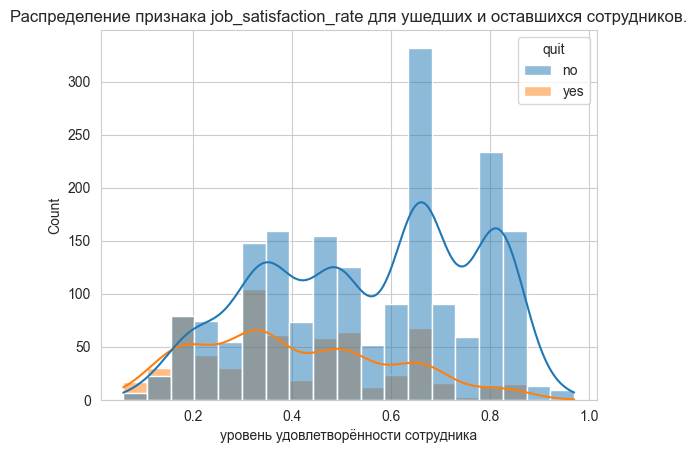

In [48]:
sns.histplot(data=train_quit, x='job_satisfaction_rate', hue='quit', kde=True);
plt.title('Распределение признака job_satisfaction_rate для ушедших и оставшихся сотрудников.')
plt.xlabel('уровень удовлетворённости сотрудника')
quit_dep = plt.gcf()

Действительно удовлетворенность сотрудников у ушедших сотрудников меньше, чем у оставшихся.

### Подготовка данных

Также предварительно объединим таблицы

In [49]:
test_data_2 = test_data.merge(test_target_quit, on='id')
test_data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   dept                   1998 non-null   object 
 2   level                  1999 non-null   object 
 3   workload               2000 non-null   object 
 4   employment_years       2000 non-null   int64  
 5   last_year_promo        2000 non-null   object 
 6   last_year_violations   2000 non-null   object 
 7   supervisor_evaluation  2000 non-null   int64  
 8   salary                 2000 non-null   int64  
 9   job_satisfaction_rate  2000 non-null   float64
 10  quit                   2000 non-null   object 
dtypes: float64(1), int64(4), object(6)
memory usage: 172.0+ KB


Данные объединились нормально.

In [50]:
X_train_2 = train_quit.drop(['id', 'quit'], axis=1)
y_train_2 = train_quit['quit'].map({'yes': 1, 'no': 0})
X_test_2 = test_data_2.drop(['id', 'quit'], axis=1)
y_test_2 = test_data_2['quit'].map({'yes': 1, 'no': 0})

In [51]:
ohe_cols_2 = ['last_year_promo', 'last_year_violations']
ord_cols_2 = ['level', 'dept', 'workload', 'supervisor_evaluation']
num_cols_2 = ['employment_years', 'salary', 'job_satisfaction_rate']

In [52]:
ohe_pipe_2 = Pipeline([
    (
        'simpleimputer_ohe', 
         SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    ),
    (
        'ohe', 
        OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
    )
])

ord_pipe_2 = Pipeline([
    (
        'simpleimputer_before_ord', 
         SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    ),
    (
        'ord', 
        OrdinalEncoder(categories=[
                                    ['junior', 'middle', 'sinior'],
                                    ['sales', 'hr', 'marketing', 'purchasing', 'technology'],
                                    ['low', 'medium', 'high'],
                                    [1, 2, 3, 4, 5]
                                  ],
                       handle_unknown='use_encoded_value', 
                       unknown_value=np.nan
                      )
    ),
    (
        'simpleimputer_fater_ord', 
         SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    )
])

#итоговый пайплайн для подготовки данных
data_preprocessor_2 = ColumnTransformer([
    ('ohe', ohe_pipe_2, ohe_cols_2),
    ('ord', ord_pipe_2, ord_cols_2),
    ('num', StandardScaler(), num_cols_2)
], remainder='passthrough')

### Обучение модели

In [53]:
class_pipeline = Pipeline([
    ('preprocessor', data_preprocessor_2),
    ('models', LogisticRegression(random_state=RANDOM_STATE))
])

In [54]:
class_pipeline.fit(X_train_2, y_train_2)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleimputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleimputer_before_ord',...
                                                                                               'technology'],
                                                                                              ['low',
                                                                                               'medium',
                                                                                               'high'],
                                                                                              [1,
                                                                                               2,
                                                                                               3,
                                                                                               4,
                                                                                               5]],
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan)),
                                                                  ('simpleimputer_fater_ord',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['level', 'dept', 'workload',
                                                   'supervisor_evaluation']),
                                                 ('num', StandardScaler(),
                                                  ['employment_years', 'salary',
                                                   'job_satisfaction_rate'])])),
                ('models', LogisticRegression(random_state=1000))])

In [55]:
roc_auc_score(y_test_2, class_pipeline.predict_proba(X_test_2)[:,1])

0.9079508188624824

In [56]:
class_param_grid = [
    # словарь для модели DecisionTreeClassifier
    {
        'models':[DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth':range(10, 21, 2),
        'models__max_features':range(5, 8),
        'models__min_samples_split':range(5, 11),
        'models__min_samples_leaf':range(1, 6),
        
        'preprocessor__num':['passthrough']            
    },
    # словарь для модели RandomForestClassifier    
    {
        'models': [RandomForestClassifier(random_state=RANDOM_STATE)],
        'models__n_estimators': [50, 100, 200, 300],
        'models__max_depth': [None, 10, 20, 30],
        'models__min_samples_leaf':[1, 2, 4, 8],
        'models__max_features':range(5, 8),


        'preprocessor__num':['passthrough']       
    },    
    # словарь для модели KNeighborsClassifier
    {
        'models':[KNeighborsClassifier()],
        'models__n_neighbors': range(3, 11),
        
        'preprocessor__num':param_num_scaler
    },
    # словарь для модели SVM
    {
        'models':[SVC(random_state=RANDOM_STATE, probability=True)],
        'models__C': [0.01, 0.1, 1, 10], 
        'models__gamma': [0.01, 0.1, 0.5, 1],
        
        'preprocessor__num':param_num_scaler
    },
    # словарь для модели LogisticRegression
    {
        'models': [LogisticRegression(penalty = 'l1',
                                      solver='saga',
                                      random_state=RANDOM_STATE,
                                      class_weight='balanced')],
        'models__C':[0.01, 0.1, 1, 10],
        
        'preprocessor__num':param_num_scaler
    }
]

Метрика оценки качества в этой задаче — ROC-AUC

In [57]:
grid_search_class = RandomizedSearchCV(class_pipeline, 
                                       class_param_grid, 
                                       cv=5, 
                                       n_iter=150,
                                       n_jobs=-1,
                                       random_state=RANDOM_STATE,
                                       scoring='roc_auc')

In [58]:
grid_search_class = grid_search_class.fit(X_train_2, y_train_2)

In [59]:
class_result = pd.DataFrame(grid_search_class.cv_results_).sort_values('rank_test_score')

y_test_pred = grid_search_class.predict(X_test_2)
y_probabiliy_one = grid_search_class.predict_proba(X_test_2)[:,1]

In [60]:
print('Всего обучено моделей:', class_result.shape[0])
print('Лучшая модель и её параметры:\n\n', grid_search_class.best_estimator_, '\n')
print ('Метрика ROC-AUC лучшей модели на тренировочной выборке:', grid_search_class.best_score_)

y_test_pred_2 = grid_search_class.predict(X_test_2)
y_test_probabiliy = grid_search_class.predict_proba(X_test_2)[:, 1]

print(f'Метрика ROC-AUC на тестовой выборке:   {roc_auc_score(y_test_2, y_test_probabiliy)}')
print(f'Метрика Accuracy на тестовой выборке:  {accuracy_score(y_test_2, y_test_pred_2)}')
print(f'Метрика F1 на тестовой выборке:        {f1_score(y_test_2, y_test_pred_2)}')

Всего обучено моделей: 150
Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleimputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
         

Почти 0.93% на тестовой выборке - на мой взгляд не самый плохой результат. Посмотрим как обстоят дела у других моделей. Выведем лучших представителей. 

In [61]:
display_best_models_grided(grid_search_class, DecisionTreeClassifier, KNeighborsClassifier, SVC, LogisticRegression, RandomForestClassifier)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessor__num,param_models__n_estimators,param_models__min_samples_leaf,param_models__max_features,param_models__max_depth,param_models,param_models__min_samples_split,param_models__n_neighbors,param_models__C,param_models__gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
23,0.285194,0.003255,0.015184,0.000710,passthrough,100.0,8.0,5.0,10,RandomForestClassifier(random_state=1000),NaN,NaN,NaN,NaN,"{'preprocessor__num': 'passthrough', 'models__...",0.914620,0.911642,0.925612,0.897223,0.924475,0.914714,0.010290,1
11,0.059831,0.012220,0.009799,0.001675,RobustScaler(),NaN,NaN,NaN,NaN,"LogisticRegression(class_weight='balanced', pe...",NaN,NaN,1.0,NaN,"{'preprocessor__num': RobustScaler(), 'models_...",0.919019,0.893297,0.901663,0.888047,0.913262,0.903058,0.011674,25
20,0.021979,0.000468,0.016446,0.000375,StandardScaler(),NaN,NaN,NaN,NaN,KNeighborsClassifier(),NaN,10.0,NaN,NaN,"{'preprocessor__num': StandardScaler(), 'model...",0.890378,0.903712,0.907922,0.893199,0.916060,0.902254,0.009465,26
113,0.420871,0.008951,0.045192,0.002034,RobustScaler(),NaN,NaN,NaN,NaN,"SVC(probability=True, random_state=1000)",NaN,NaN,10.0,0.01,"{'preprocessor__num': RobustScaler(), 'models_...",0.916948,0.899353,0.898301,0.879445,0.914725,0.901754,0.013524,28
82,0.022156,0.001979,0.008547,0.002518,passthrough,NaN,5.0,7.0,12,DecisionTreeClassifier(random_state=1000),8.0,NaN,NaN,NaN,"{'preprocessor__num': 'passthrough', 'models__...",0.886433,0.885615,0.890707,0.876152,0.907161,0.889214,0.010155,37


Почти 0.93% на тестовой выборке - на мой взгляд не самый плохой результат. Наилучшая модель RandomForestClassifier по результатам RandomizedSearchCV удовлетворяет всем требованиям заказчика и будет передена как конечная.

### Выводы

В ходе выполнения задачи по предсказанию увольнения сотрудника из компании был сформирован "портрет" работника, который уволится с наибольшей вероятностью: это работник начального уровня junior с зарплатой ниже среднего, средней/высокой загруженностью, который за первые 2 года так и не смог показать себя и получить повышение, а также с оценкой руководителя "на троечку".

Также было опробовано несколько моделей машинного обучения:
* DecisionTreeClassifier;
* KNeighborsClassifier;
* SVC;
* LogisticRegression;
* RandomForestClassifier


По результатам поиска наилучшей модели методом GridSearchCV была выбрана модель **RandomForestClassifier** с гиперпараметрами *max_depth* = **10**, *max_features* = **5**, *min_samples_leaf* = **8**.

# Общий вывод

В данном проекте я в роли аналитика HR-аналитики компании «Работа с заботой» должен был опираясь на методы машинного обучения:
1. построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика.
2. построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

>**Задача 1**

В процессе выполнения задачи были выполнены такие шаги как:
* Загрузка данных
* Предобработка данных
* Исследовательский анализ данных
* Подготовка данных
* Обучение моделей

Лучшей моделью по результатам обучения выбрана модель дерева решений RandomForestRegressor. Её пайплайн и график важности признаков приведен ниже. Метрка SMAPE для тестовой выборки составила **12.57%**.

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleimputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleimputer_before_ord',...
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan)),
                                                                  ('simpleimputer_fater_ord',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['level', 'dept', 'workload',
                                                   'supervisor_evaluation']),
                                                 ('num', 'passthrough',
                                                  ['salary',
                                                   'employment_years'])])),
                ('models',
                 RandomForestRegressor(max_depth=20, max_features=7,
                                       min_samples_leaf=2, n_estimators=350,
                                       random_state=1000))])

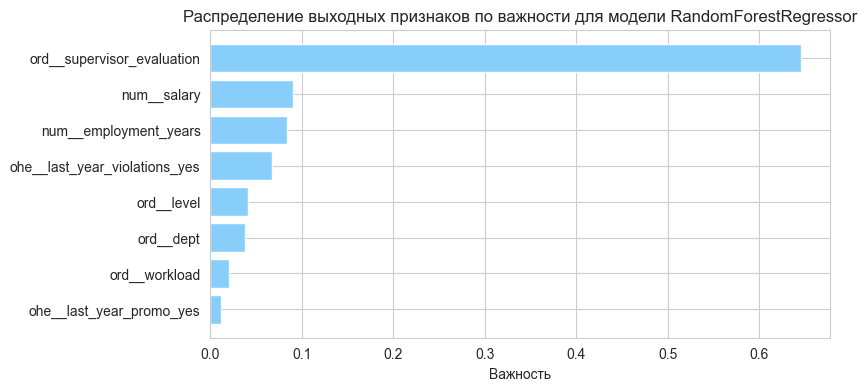

In [62]:
display(best_regression_pipeline)
tree_feature_importances

>**Задача 2**

В процессе выполнения задачи были выполнены такие шаги как:
* Загрузка данных (тренировочные данные оказали уникальными, а вот тестовые остались теми же самыми);
* Предобработка данных;
* Исследовательский анализ данных. Здесь были построены графики распределения признаков в зависимости от целевого (quit). Определен портрет «уволившегося сотрудника», визуализировано распределение признака job_satisfaction_rate для ушедших и оставшихся сотрудников;

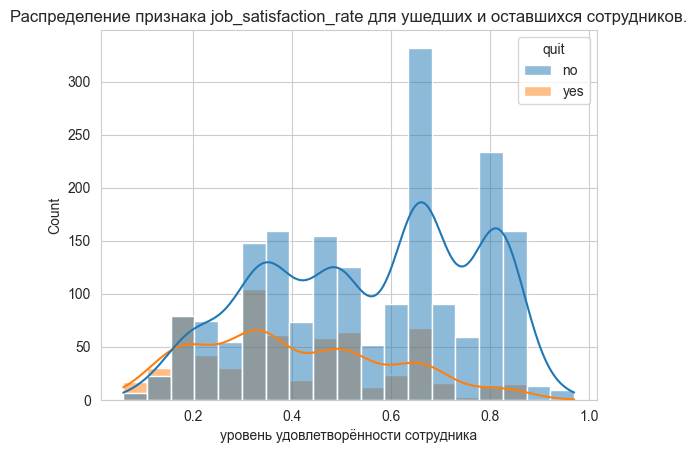

In [63]:
quit_dep

* Добавление нового входного признака job_satisfaction_rate для предсказания целевого quit;
* Подготовка данных;
* Обучение модели.

Лучшей моделью по результатам обучения выбрана модель SVC. Её пайплайн приведен ниже. Метрика ROC-AUC на тренировочной выборке составила почти **0.93%**.

In [64]:
grid_search_class.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleimputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleimputer_before_ord',...
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan)),
                                                                  ('simpleimputer_fater_ord',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['level', 'dept', 'workload',
                                                   'supervisor_evaluation']),
                                                 ('num', 'passthrough',
                                                  ['employment_years', 'salary',
                                                   'job_satisfaction_rate'])])),
                ('models',
                 RandomForestClassifier(max_depth=10, max_features=5,
                                        min_samples_leaf=8,
                                        random_state=1000))])

## Заключение

Для удержания персонала нужно обратить внимание на взаимоотношение работников и их руководителей. При улучшении их взаимоотношений и коммуникации - будет лучше результат. Лучше результат - более довольный руководитель и работник. Довольный работник - низкий отток перонала. Конечно, не менее важным я считаю достойный уровень заработной платы. С количеством проработанных лет все закономерно: чем дольше работник работает - тем меньше вероятность его ухода (значит его все устраивает), согласно тренировочным данным "текучка" сильно уменьшается после 4 лет.